In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error



#matplolib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [4]:
# total number of cells with missing values
print("Number of cells with the missing values are {}".format((df.isnull().sum()).sum()))

Number of cells with the missing values are 6965


In [5]:
# seperating numerical and categorical variabled for EDA and feature engineering

num_cols = [col for col in df.columns if df[col].dtype in ['int64','float64']]

cat_cols = [col for col in df.columns if df[col].dtype == 'object']

y = df['SalePrice']

# numerical and categorical dataframe

num_df = df[num_cols]
cat_df = df[cat_cols]

In [6]:
# EDA and feature engineering on numerical cols

num_df.dropna(axis=1, inplace=True)

num_df.nunique()

MSSubClass         15
LotArea          1073
OverallQual        10
OverallCond         9
YearBuilt         112
YearRemodAdd       61
BsmtFinSF1        637
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
1stFlrSF          753
2ndFlrSF          417
LowQualFinSF       24
GrLivArea         861
BsmtFullBath        4
BsmtHalfBath        3
FullBath            4
HalfBath            3
BedroomAbvGr        8
KitchenAbvGr        4
TotRmsAbvGrd       12
Fireplaces          4
GarageCars          5
GarageArea        441
WoodDeckSF        274
OpenPorchSF       202
EnclosedPorch     120
3SsnPorch          20
ScreenPorch        76
PoolArea            8
MiscVal            21
MoSold             12
YrSold              5
SalePrice         663
dtype: int64

In [7]:
cols = [col for col in num_df.columns if num_df[col].nunique() > 15 ] 

cols.remove('SalePrice')

conti_fea = num_df[cols]

# 1. Numerical columns data analysis

> Below code will give us bivariate analysis of continous features and its releationship with our target

> we can see that some features are more likely to co-relate than others and we will cross check with mutual info regressor as well

<Figure size 360x360 with 0 Axes>

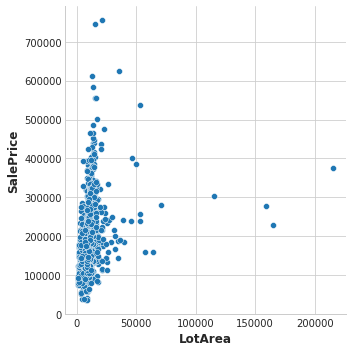

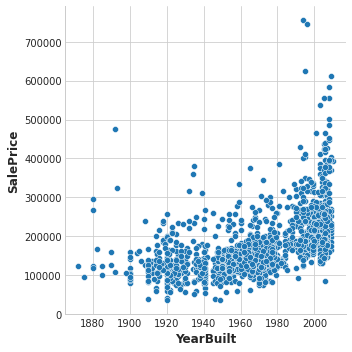

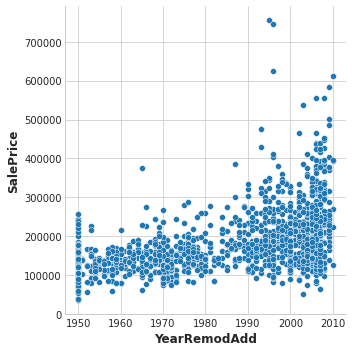

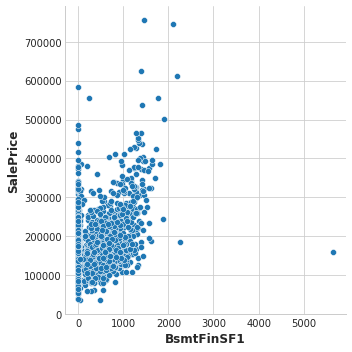

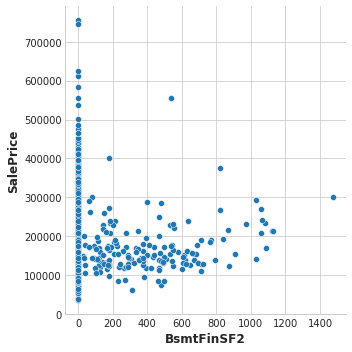

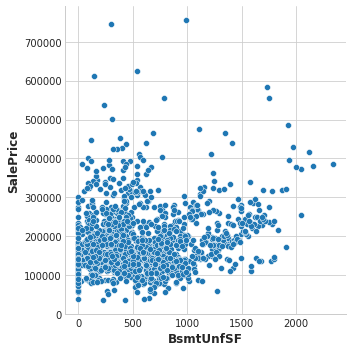

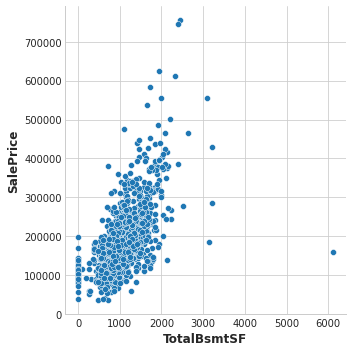

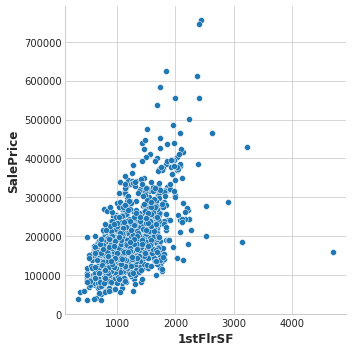

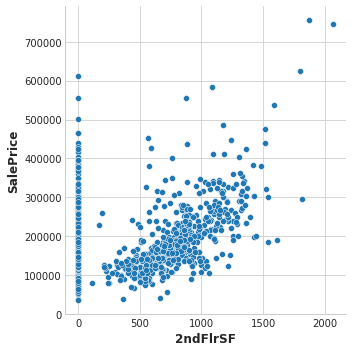

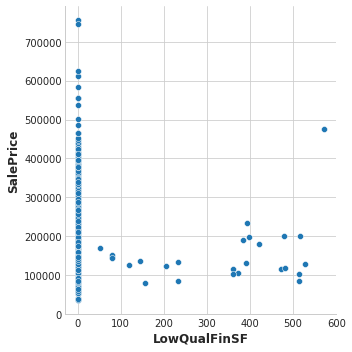

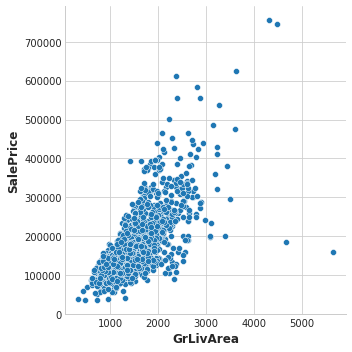

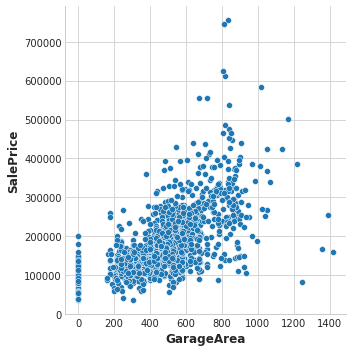

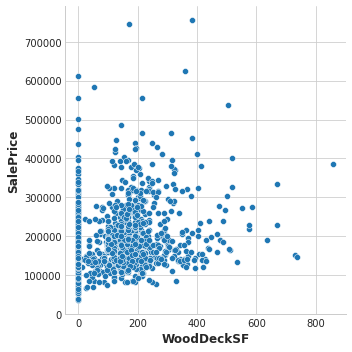

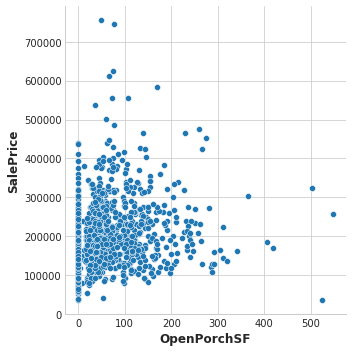

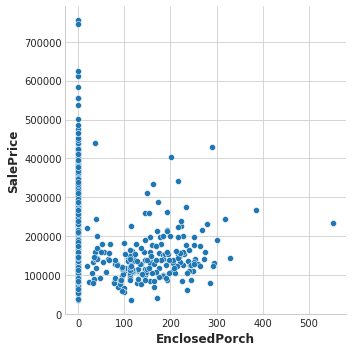

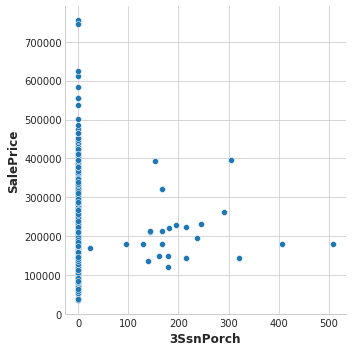

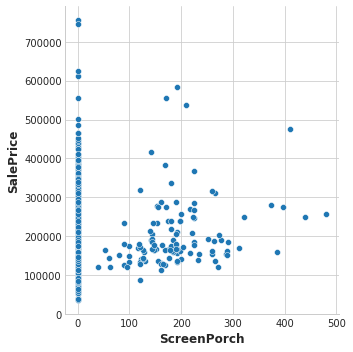

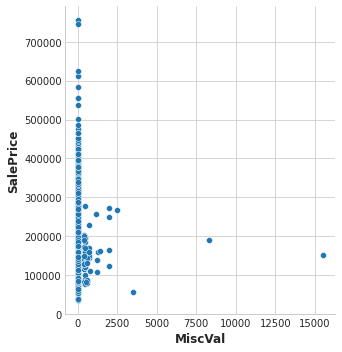

In [8]:
for idx, col in enumerate(conti_fea.columns):
    plt.figure(idx, figsize=(5,5))
    sns.relplot(x=col, y=y, kind="scatter", data=conti_fea)
    plt.show

> From above plots we can see that 'Yearbuilt', 'YearRemodadd', 'GrLivArea', 'GarageArea' highly co-relate with our target 'SalePrice'

In [9]:
cols = [col for col in num_df.columns if num_df[col].nunique() <= 15 ] 

dist_feature = num_df[cols]
dist_feature.head()

,MSSubClass,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,PoolArea,MoSold,YrSold
Id,,,,,,,,,,,,,,,
1,60,7,5,1,0,2,1,3,1,8,0,2,0,2,2008
2,20,6,8,0,1,2,0,3,1,6,1,2,0,5,2007
3,60,7,5,1,0,2,1,3,1,6,1,2,0,9,2008
4,70,7,5,1,0,1,0,3,1,7,1,3,0,2,2006
5,60,8,5,1,0,2,1,4,1,9,1,3,0,12,2008


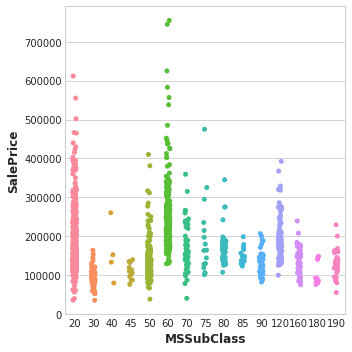

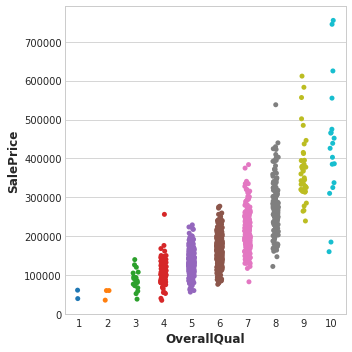

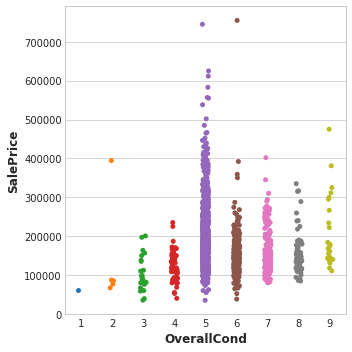

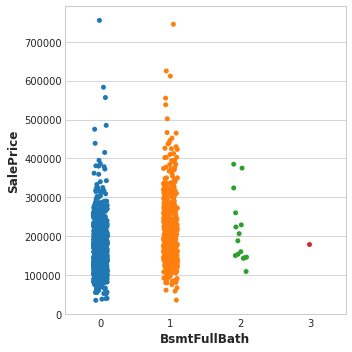

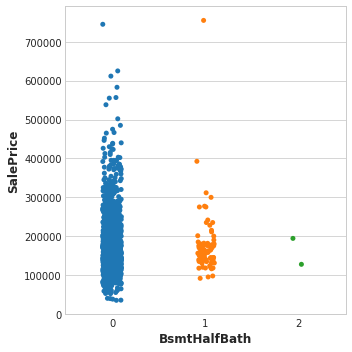

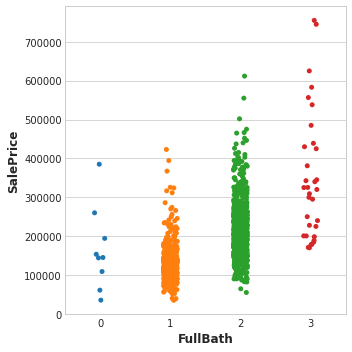

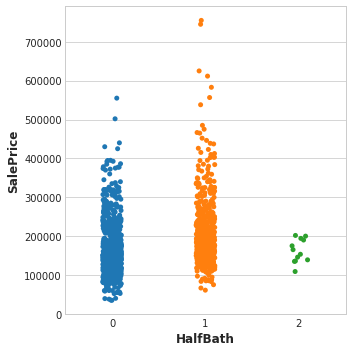

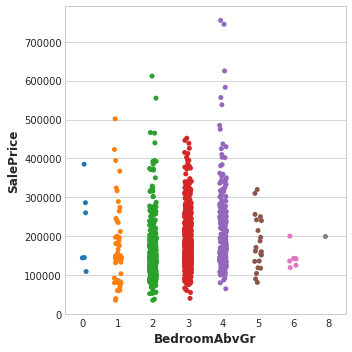

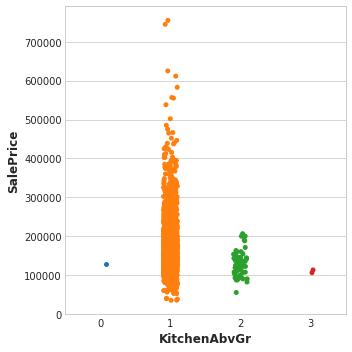

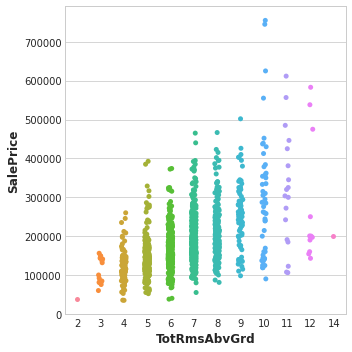

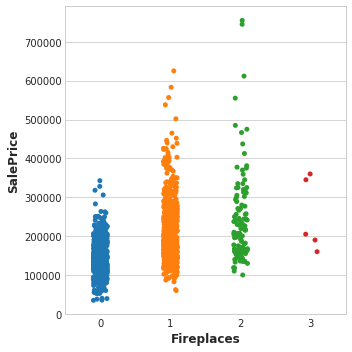

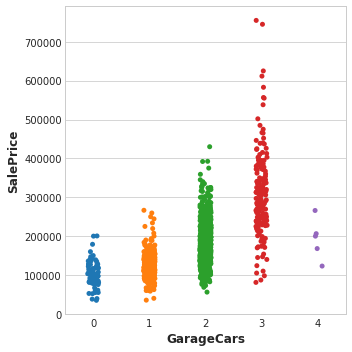

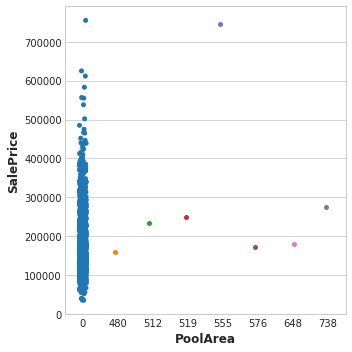

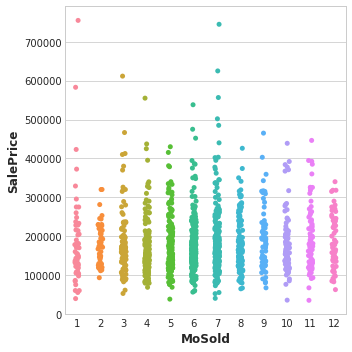

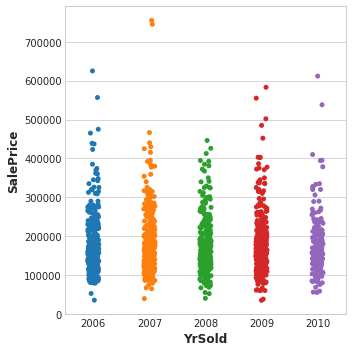

In [10]:
for idx, col in enumerate(dist_feature.columns):
    plt.figure(idx, figsize=(5,5))
    sns.stripplot(x=col , y=y , data=dist_feature)
    plt.show

> From above plots we can clearly see that 'MSSubclass', 'YrSold', 'MoSold', 'PoolArea' are not informative features and will examine them in mutual info regressor

In [11]:
# MI score on num_df dataframe
#nti_fea = num_df[cols]
#ist_feature = num_df[cols]

X = num_df.drop('SalePrice', axis=1)

y = df['SalePrice']

#iscrete_features = dist_feature

def mi_score(X,y):
    mi_score = mutual_info_regression(X,y, discrete_features=False, random_state=0)
    mi_score = pd.Series(mi_score, name="MI_SCORE", index=X.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

mi_series = mi_score(X,y)

#i_df = pd.DataFrame(mi_series, columns="MI_SCORE", index = mi_series.index)

pd.DataFrame(mi_series)

,MI_SCORE
OverallQual,0.524266
GrLivArea,0.378106
GarageCars,0.367277
GarageArea,0.288072
YearBuilt,0.268349
FullBath,0.260929
TotalBsmtSF,0.259320
1stFlrSF,0.232309
YearRemodAdd,0.190501
TotRmsAbvGrd,0.188863


> From above plots and MI_score we will consider features having score above **0.15** to keep most informative features in our model training dataset.

> We will do feature engineering and outliers handling on these features

<function matplotlib.pyplot.show(close=None, block=None)>

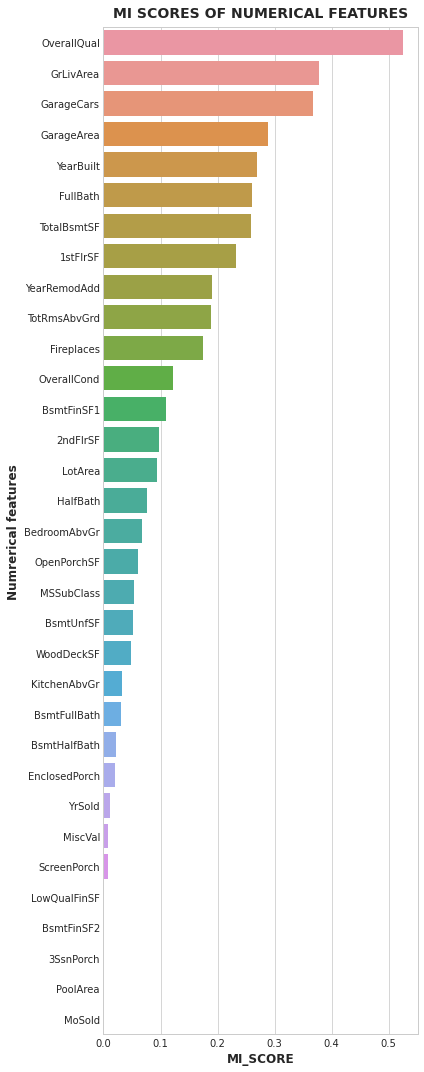

In [12]:
# plootting MI scores of numrical data analysis
data=pd.DataFrame(mi_series)

fig, ax = plt.subplots(figsize=(6,15))

ax.set_title("MI SCORES OF NUMERICAL FEATURES")
sns.barplot(data=data, y=data.index, x='MI_SCORE', ax=ax)
ax.set_ylabel("Numrerical features")

plt.show

# 2. Categorical columns data analysis

> We will do bivariate analysis of categorical features to see how they explains our target variable

In [13]:
cat_df = df[cat_cols]
cat_df.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [14]:
#cat_df.isnull().sum()

# remove features wiht most number of data missing

features_rem = [col for col in cat_df.columns if cat_df[col].isnull().sum() > 500]

cat_df = cat_df.drop(features_rem, axis=1)

cat_df.fillna(method='bfill', axis=1, inplace=True)

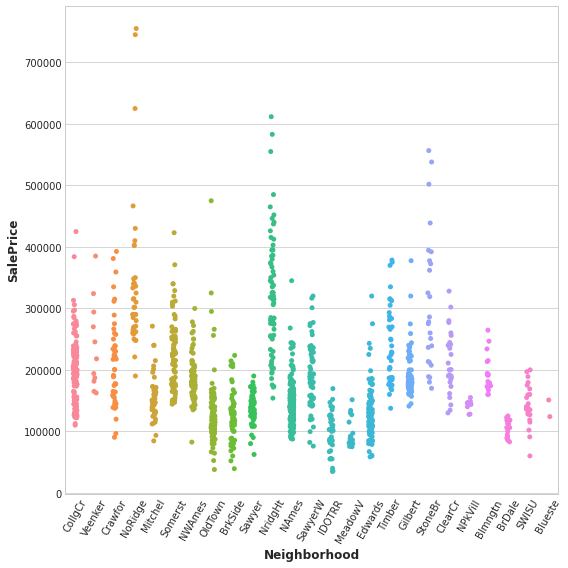

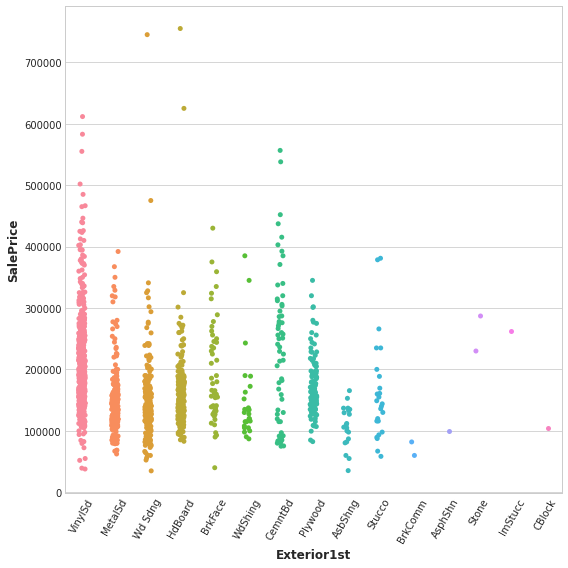

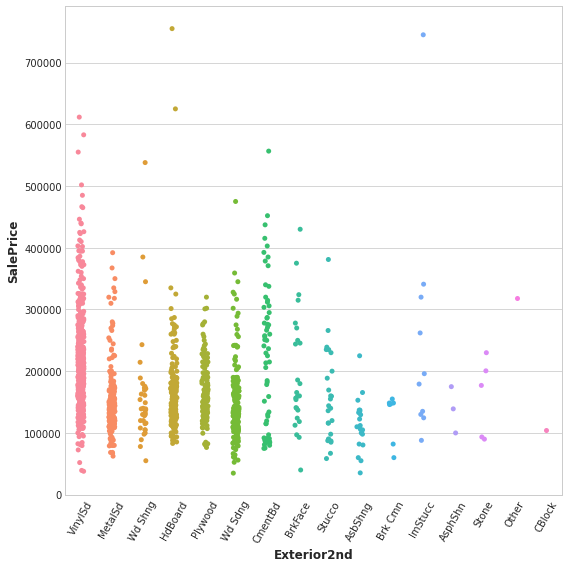

In [15]:
# plotting categorical features to find releationship with our target variable

y = df['SalePrice']

col_15 = [col for col in cat_df.columns if cat_df[col].nunique() >= 15]

for idx, col in enumerate(col_15):
    plt.figure(idx, figsize=(8,8))
    sns.stripplot(x=col, y=y, data=cat_df[col_15])
    plt.xticks(rotation=60)
    plt.show

> From these plots we can say that above features contains no information to explain our target variable as we have more uncertainity 

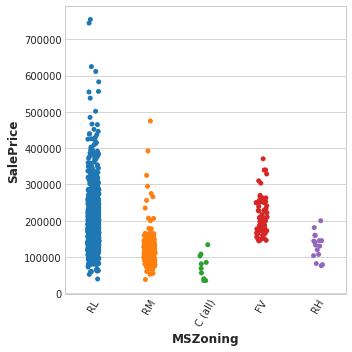

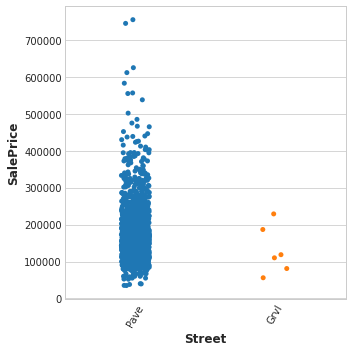

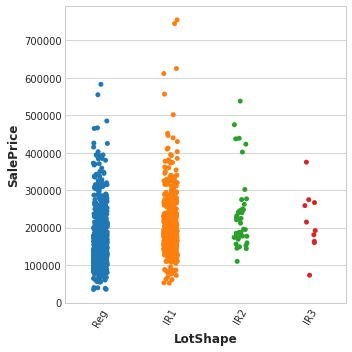

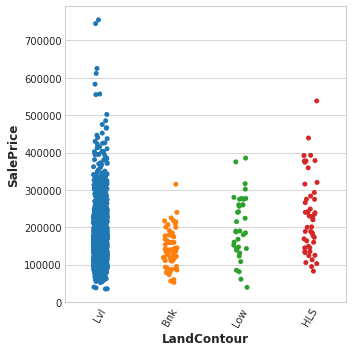

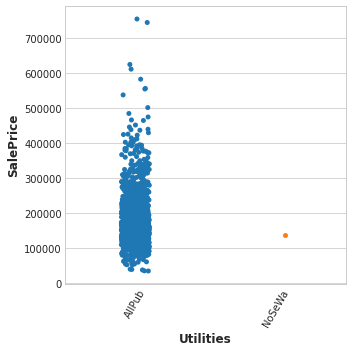

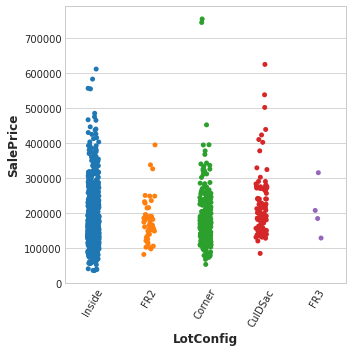

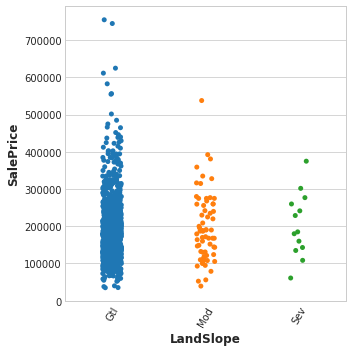

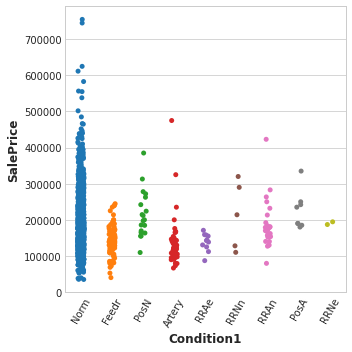

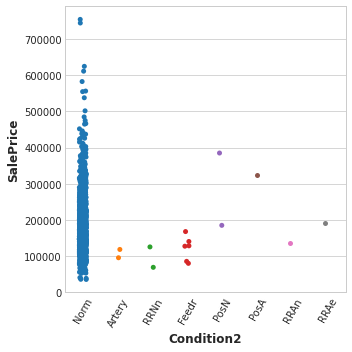

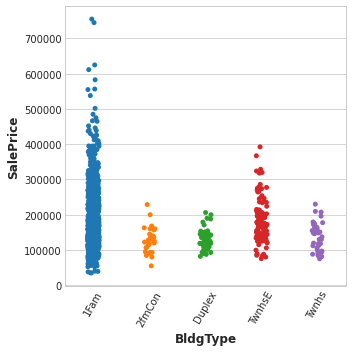

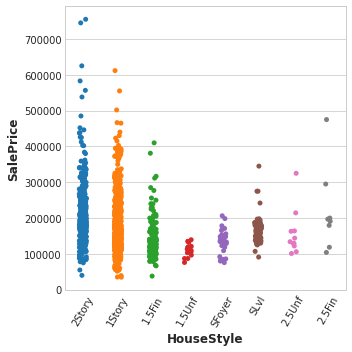

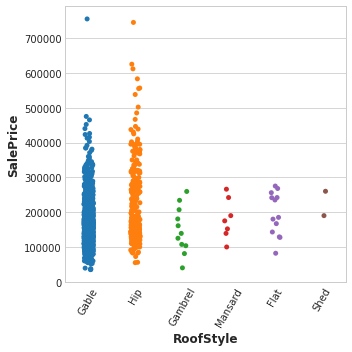

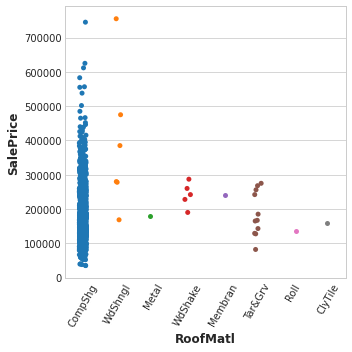

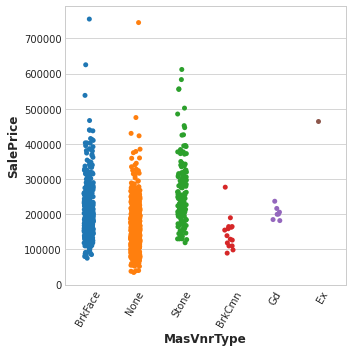

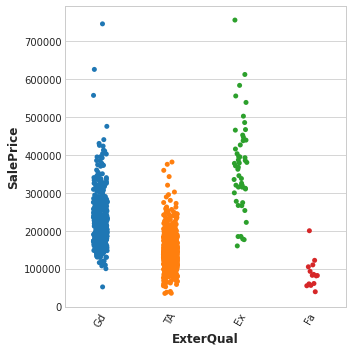

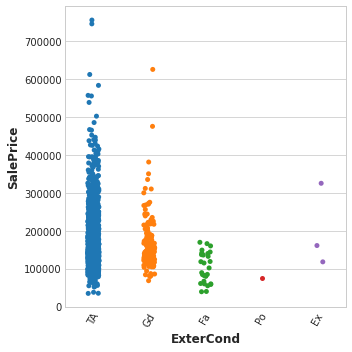

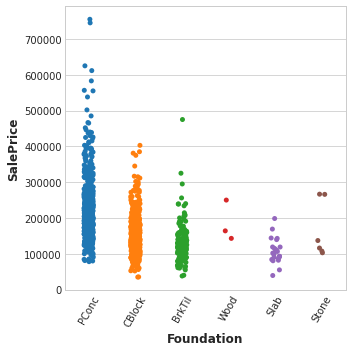

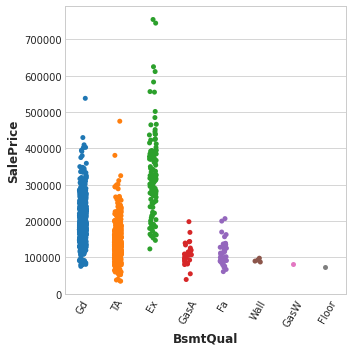

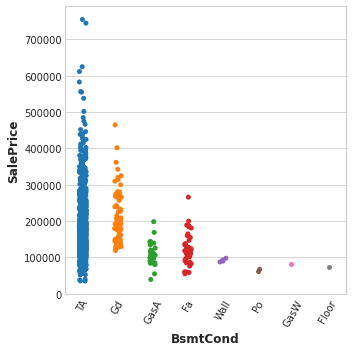

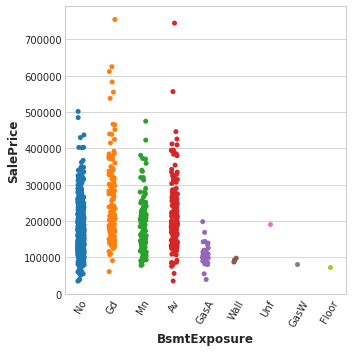

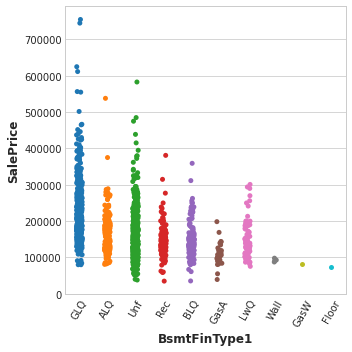

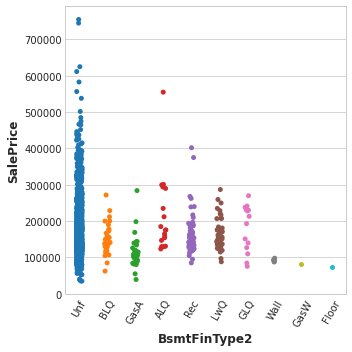

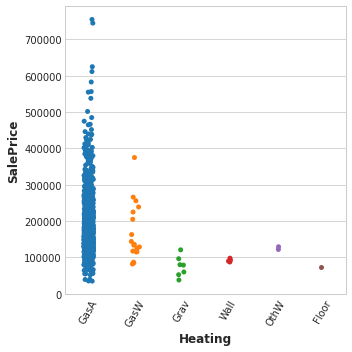

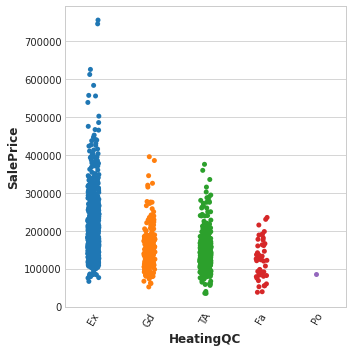

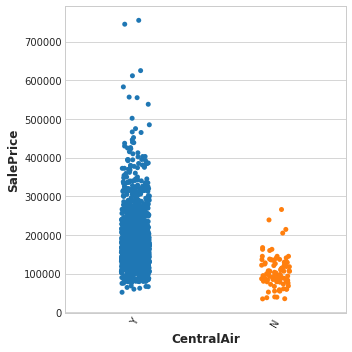

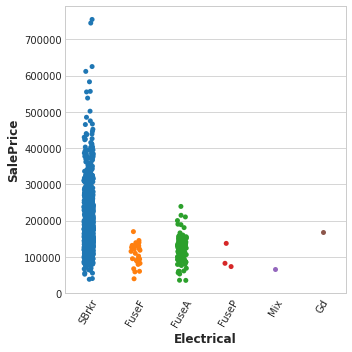

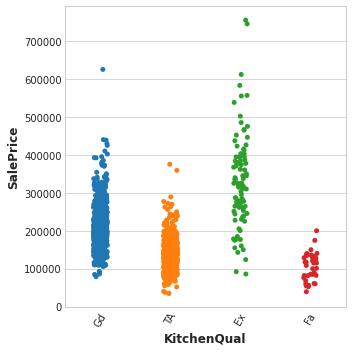

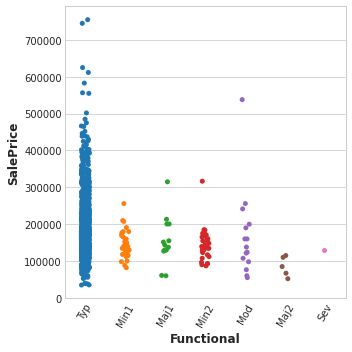

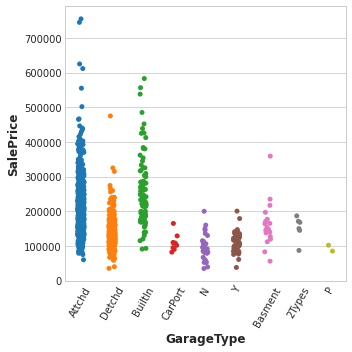

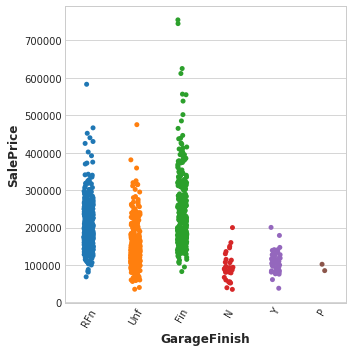

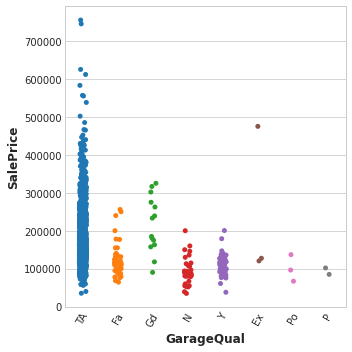

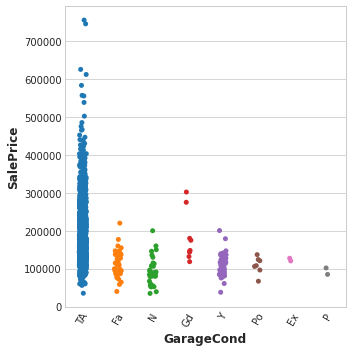

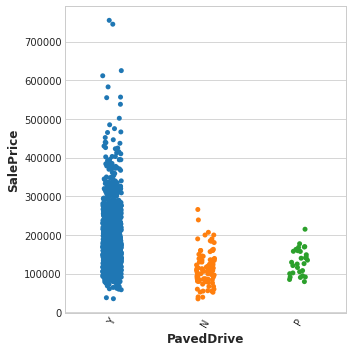

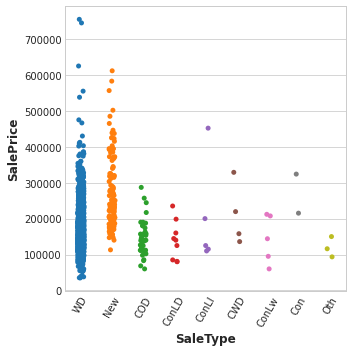

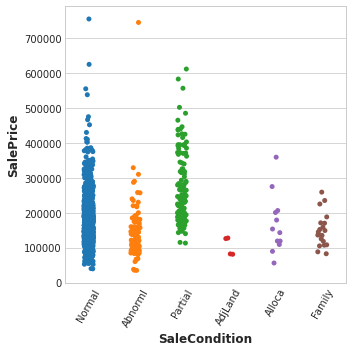

In [16]:
y = df['SalePrice']

cols_ = [col for col in cat_df.columns if cat_df[col].nunique() < 15]

for idx, col in enumerate(cols_):
    plt.figure(idx, figsize=(5,5))
    sns.stripplot(x=col, y=y, data=cat_df[cols_])
    plt.xticks(rotation=60)
    plt.show

> Some of the features like 'Street', 'BldgType', 'PavedDrive', 'Garagecond', 'HeatingQC' are more informative and explains target variable with less antropy than others

In [17]:
# Mutual info regressio on categorical features
y = df['SalePrice']
X1 = cat_df[cols_]

for colname in X1.select_dtypes('object'):
    X1[colname],_= X1[colname].factorize()

miscore = mutual_info_regression(X1, y, random_state=0)
miscore = pd.Series(miscore, name="MISCORE", index = X1.columns)
miscore = miscore.sort_values(ascending=False)

pd.DataFrame(miscore)

,MISCORE
BsmtQual,0.333517
KitchenQual,0.327290
ExterQual,0.319011
GarageFinish,0.263914
Foundation,0.201812
HeatingQC,0.166887
MSZoning,0.133408
MasVnrType,0.102305
BsmtFinType1,0.085997
GarageQual,0.082772


<function matplotlib.pyplot.show(close=None, block=None)>

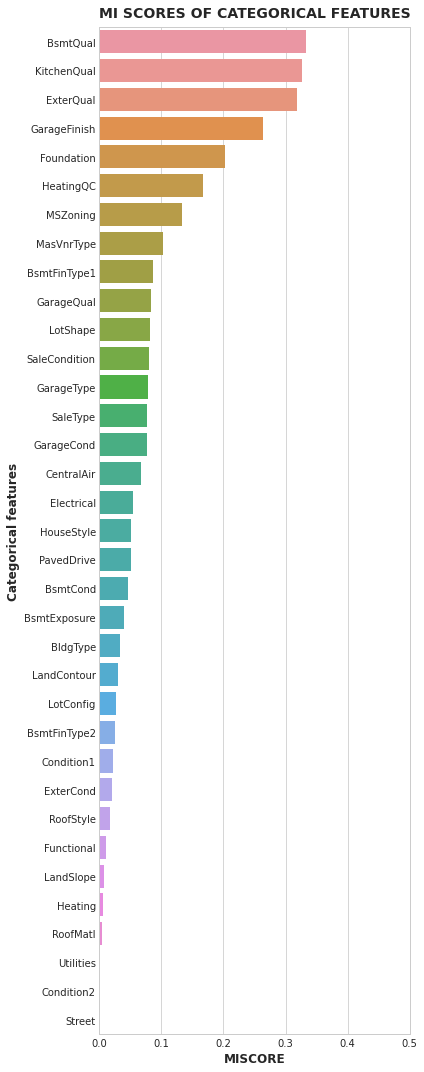

In [18]:
# plootting MI scores of numrical data analysis
data = pd.DataFrame(miscore)

fig, ax = plt.subplots(figsize=(6,15))

ax.set_title("MI SCORES OF CATEGORICAL FEATURES")
sns.barplot(data=data, y=data.index, x='MISCORE', ax=ax)
ax.set_ylabel("Categorical features")
ax.set_xlim(0,0.5)

plt.show

> We will keep features having MI score of **0.15** and above in our model training 

<function matplotlib.pyplot.show(close=None, block=None)>

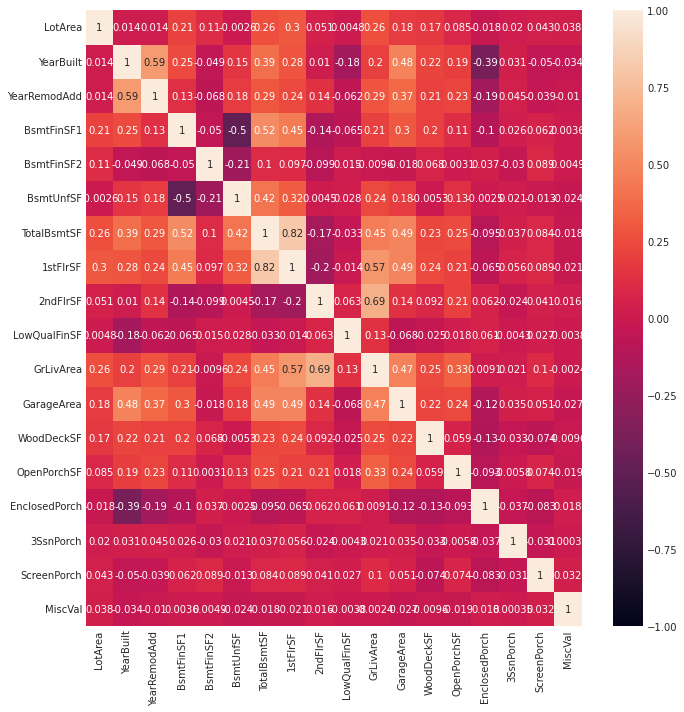

In [19]:
# corelation matrix for numerical continues features
plt.figure(figsize=(10,10))
sns.heatmap(data=conti_fea.corr(), annot=True, vmin=-1, vmax=1)
plt.show

In [20]:
# features transformations and  new features addition

# ratio of ground live area and frist floor area

num_df['grlivperfirstflr'] = num_df['GrLivArea']/num_df['1stFlrSF']

# total number of porch types

num_df['Porchtypes'] = num_df[['ScreenPorch','3SsnPorch',
                               'EnclosedPorch','OpenPorchSF','WoodDeckSF']].gt(0).sum(axis=1)

# we can see from above numerical plots that houses with 2nd floor highly correlate with price of the house
# but are not having all house with 2nd floor so will tell model that what houses are having 2nd floor

num_df['2nd_flr'] = np.where(num_df['2ndFlrSF'].map(lambda x: x>0), 1 ,0) 

# total number of bathrooms 

num_df['Totalbath'] = (num_df['HalfBath'] + 
                       num_df['FullBath'] + 
                       num_df['BsmtHalfBath'] +   
                       num_df['BsmtFullBath'])

# mean saleprice surrounded by each Neighborhood 

num_df['MeanpriceNBH'] = df.groupby('Neighborhood').SalePrice.transform('mean')

In [21]:
#num_df.head()

In [22]:
data=pd.DataFrame(mi_series)
arr = np.array(data.index)

feature1 = []

for fea in arr:
    if data.loc[fea,'MI_SCORE'] > 0.15:
        feature1.append(fea)
    else:
        pass

feature1

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'YearBuilt',
 'FullBath',
 'TotalBsmtSF',
 '1stFlrSF',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'Fireplaces']

In [23]:
#X1.head()

In [24]:
data2 = pd.DataFrame(miscore)
arr2 = np.array(data2.index)

feature2 = []

for fea in arr2:
    if data2.loc[fea,'MISCORE'] > 0.15:
        feature2.append(fea)
    else:
        pass
    
feature2

['BsmtQual',
 'KitchenQual',
 'ExterQual',
 'GarageFinish',
 'Foundation',
 'HeatingQC']

In [25]:
# combining all transformd data and creating one single dataframe for model traning

In [26]:
feature3 = ['grlivperfirstflr','Porchtypes','2nd_flr','Totalbath','MeanpriceNBH']

# 3. K-means clustering

In [27]:
# we will cluster houses based on area ocuupied by various floors and basement

feat = ['GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF','2ndFlrSF']

def clusters(df):
    X = df.copy()
    X_scaled = (X - X.mean(axis=0))/X.std(axis=0)
    kmeans = KMeans(n_clusters=15, n_init=10, max_iter=400, random_state=0)
    kmeans = kmeans.fit_predict(X_scaled)
    X['clusters'] = np.array(kmeans)
    return X

clustering_df = clusters(num_df[feat])

clustering_df

,GrLivArea,GarageArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,clusters
Id,,,,,,
1,1710,548,856,856,854,0
2,1262,460,1262,1262,0,4
3,1786,608,920,920,866,0
4,1717,642,756,961,756,0
5,2198,836,1145,1145,1053,6
...,...,...,...,...,...,...
1456,1647,460,953,953,694,0
1457,2073,500,1542,2073,0,1
1458,2340,252,1152,1188,1152,12


<Figure size 432x432 with 0 Axes>

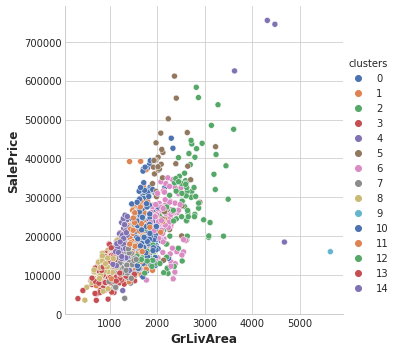

<Figure size 432x432 with 0 Axes>

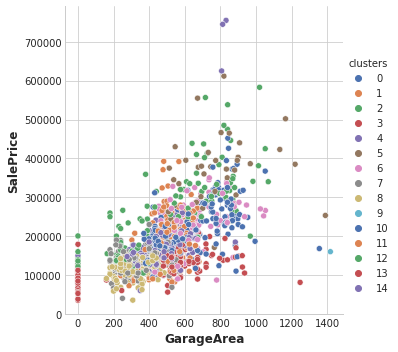

<Figure size 432x432 with 0 Axes>

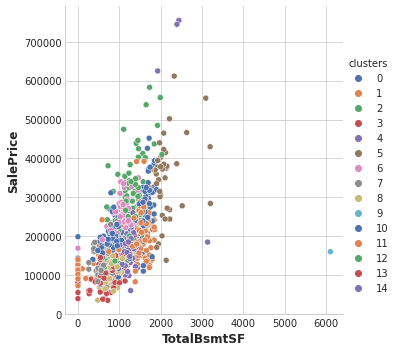

<Figure size 432x432 with 0 Axes>

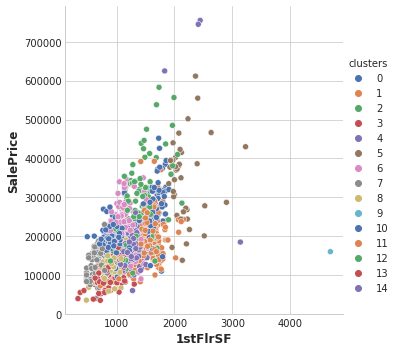

<Figure size 432x432 with 0 Axes>

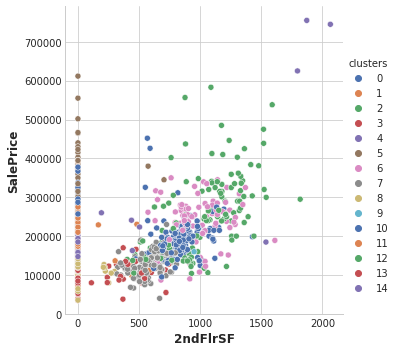

In [28]:
y = df['SalePrice']
feat = ['GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF','2ndFlrSF']
# plotting clusters and its significance on our target

for idx,col in enumerate(feat):
    plt.figure(idx, figsize=(6,6))
    sns.relplot(x=col,
            y=y, 
            hue='clusters',
            kind='scatter',
            palette='deep',
            data=clustering_df)
    plt.show()

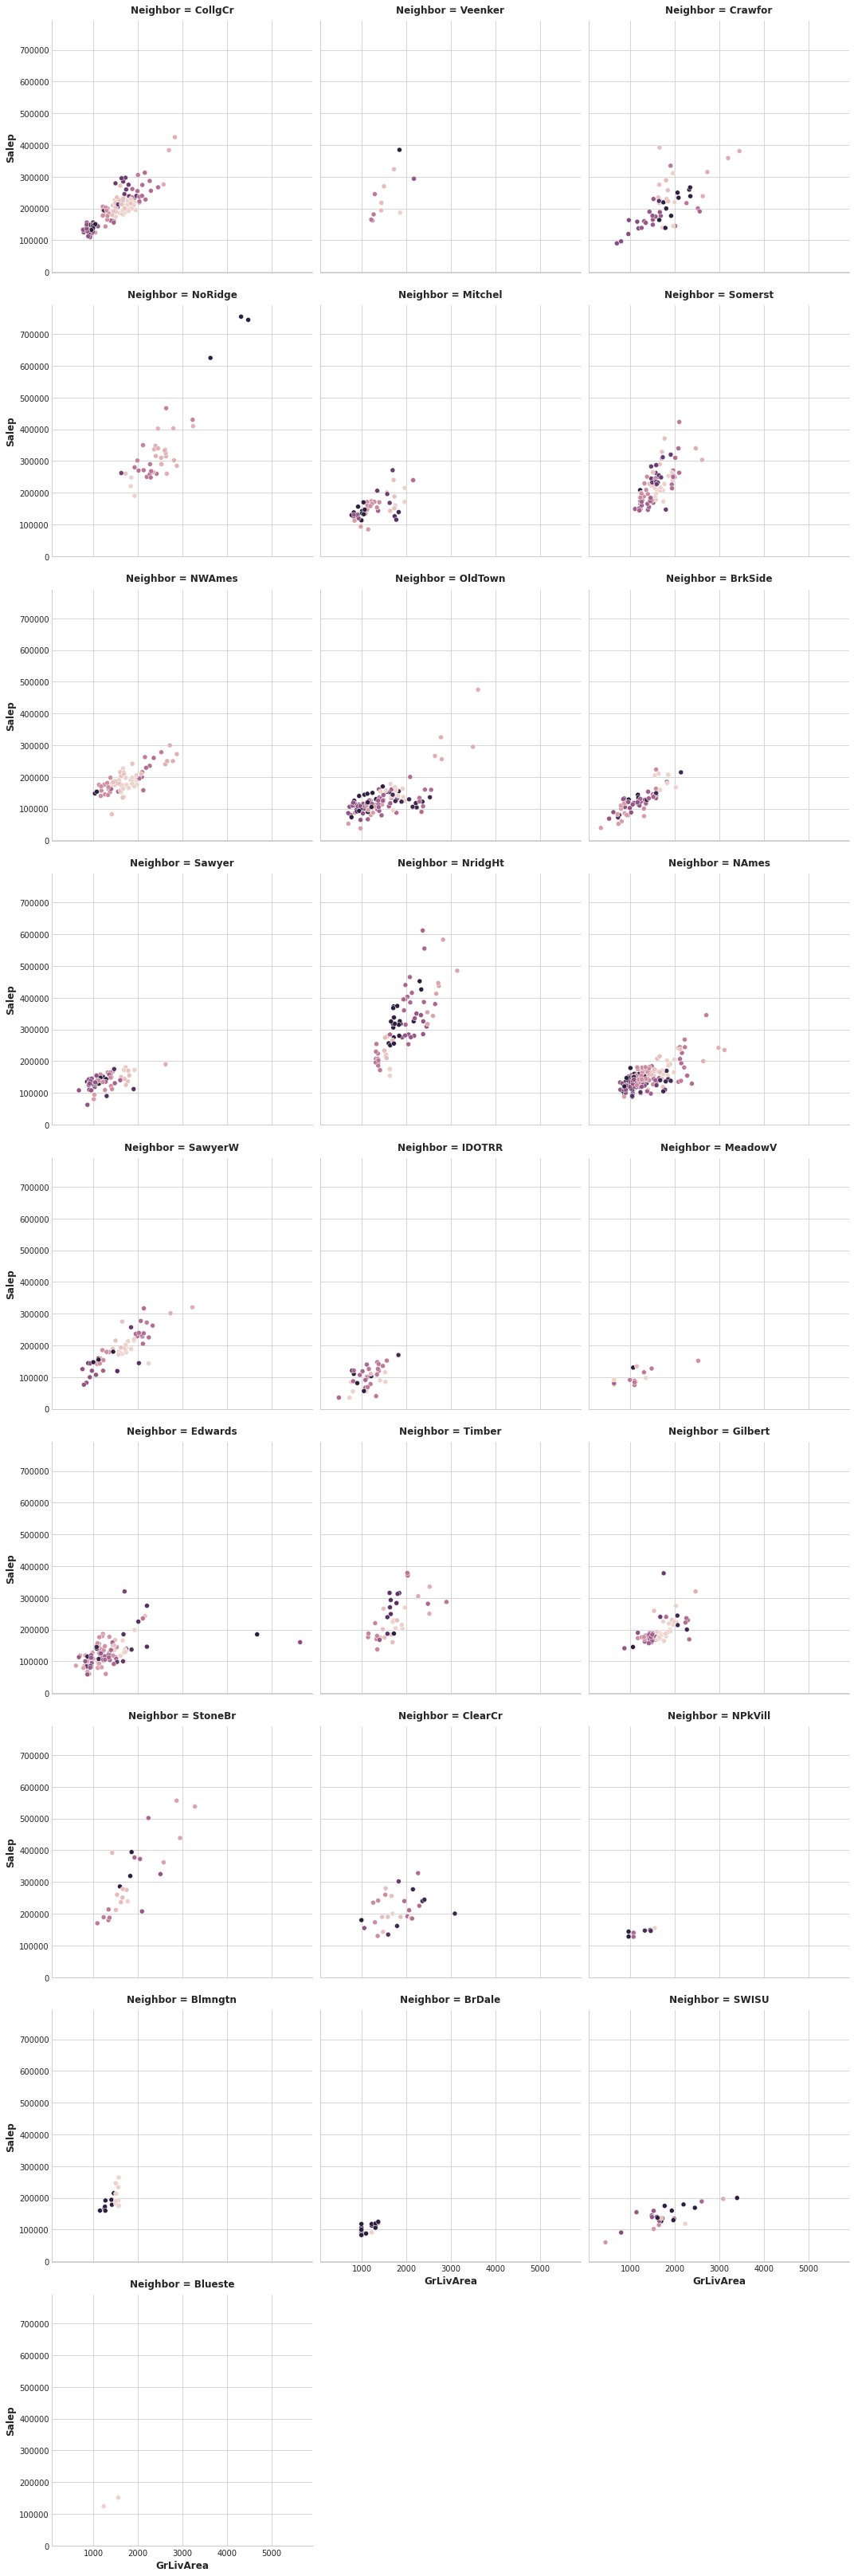

In [29]:
data2 = clustering_df.copy()
data2['Neighbor'] = df['Neighborhood']
data2['Salep'] = df['SalePrice']

# plotting using facet grid categorising via neighborhood

g = sns.FacetGrid(data2, col='Neighbor',height= 5,
                aspect= 1,
                col_wrap=3,
                palette='deep')
g.map_dataframe(sns.scatterplot,
                x='GrLivArea', 
                y='Salep', 
                hue='clusters')

# 4. Training dataset preparation

In [30]:
# ccategorical dataframe and numerical dataframe

d1 = X1[feature2]
d = num_df[feature1+feature3]

In [31]:
# normalising data frame
d2 = d - d.mean(axis=0)/d.std(axis=0)

# concating dataframes d1 and d2

X = d2.join(d1, how='left')
X = round(X,1)
X = X.astype('int')
y = df['SalePrice']

# splitting train and validation dataset

X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size=0.8, 
                                                      test_size=0.2,random_state=0)

# 5. Hyperparamters tuning and models training

In [32]:
def results(results):
    print('Best Params {}\n'.format(results.best_params_))
    print('Best Estimator {}\n'.format(results.best_estimator_))
    
    meanscore = results.cv_results_['mean_test_score']
    stdscore  = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean, std, param in zip(meanscore,stdscore,params):
        print('{} (+/-{}) for {}'.format(round(mean),round(std),param))

In [33]:
#mlp = MLPRegressor()

#params = {'hidden_layer_sizes':[(100,),(150,2)],
#          'activation':['identity','tanh','relu'],
 #         'solver':['lbfgs','sgd','adam'],
 #         'learning_rate':['constant','invscaling','adaptive'],
  #        'max_iter':[500,1000]
  #        }

#cv1 = GridSearchCV(mlp, params, cv=5, scoring='neg_mean_absolute_error')
#cv1.fit(X_train,y_train)

#results(cv1)

In [34]:
# we will train first model via stochastic gradient descent regressor

sgd = SGDRegressor()
params = {'loss': ['squared_loss','huber'],
          'max_iter': [500,1000,1500],
          'learning_rate': ['constant', 'optimal', 'invscaling'],
          'penalty': ['l2','l1','elasticnet']
          }

cv = GridSearchCV(sgd, params, cv=5, scoring='neg_mean_absolute_error')
cv.fit(X_train, y_train)

results(cv)

Best Params {'learning_rate': 'invscaling', 'loss': 'huber', 'max_iter': 1500, 'penalty': 'l2'}

Best Estimator SGDRegressor(loss='huber', max_iter=1500)

-100257038748364980224 (+/-36675241538294665216) for {'learning_rate': 'constant', 'loss': 'squared_loss', 'max_iter': 500, 'penalty': 'l2'}
-108020905667633594368 (+/-45780884676972765184) for {'learning_rate': 'constant', 'loss': 'squared_loss', 'max_iter': 500, 'penalty': 'l1'}
-233606670848150700032 (+/-110354459254477258752) for {'learning_rate': 'constant', 'loss': 'squared_loss', 'max_iter': 500, 'penalty': 'elasticnet'}
-191893834636434767872 (+/-144119655296879558656) for {'learning_rate': 'constant', 'loss': 'squared_loss', 'max_iter': 1000, 'penalty': 'l2'}
-113422821710513487872 (+/-43257438172269305856) for {'learning_rate': 'constant', 'loss': 'squared_loss', 'max_iter': 1000, 'penalty': 'l1'}
-124565046685327376384 (+/-123618860247005593600) for {'learning_rate': 'constant', 'loss': 'squared_loss', 'max_iter': 1000, 'p

In [35]:
# using random forest regressor

rfr = RandomForestRegressor()

params = {'n_estimators':[100,200,500],
          'max_depth':[5,8,10,15,20],
          'max_leaf_nodes':[50,100,150]
         }

cv1 = GridSearchCV(rfr, params, cv=5, scoring = 'neg_mean_absolute_error')
cv1.fit(X_train,y_train)

results(cv1)

Best Params {'max_depth': 20, 'max_leaf_nodes': 150, 'n_estimators': 500}

Best Estimator RandomForestRegressor(max_depth=20, max_leaf_nodes=150, n_estimators=500)

-20631 (+/-2677) for {'max_depth': 5, 'max_leaf_nodes': 50, 'n_estimators': 100}
-20548 (+/-2573) for {'max_depth': 5, 'max_leaf_nodes': 50, 'n_estimators': 200}
-20459 (+/-2451) for {'max_depth': 5, 'max_leaf_nodes': 50, 'n_estimators': 500}
-20519 (+/-2499) for {'max_depth': 5, 'max_leaf_nodes': 100, 'n_estimators': 100}
-20457 (+/-2427) for {'max_depth': 5, 'max_leaf_nodes': 100, 'n_estimators': 200}
-20476 (+/-2417) for {'max_depth': 5, 'max_leaf_nodes': 100, 'n_estimators': 500}
-20577 (+/-2438) for {'max_depth': 5, 'max_leaf_nodes': 150, 'n_estimators': 100}
-20424 (+/-2422) for {'max_depth': 5, 'max_leaf_nodes': 150, 'n_estimators': 200}
-20474 (+/-2547) for {'max_depth': 5, 'max_leaf_nodes': 150, 'n_estimators': 500}
-19370 (+/-2555) for {'max_depth': 8, 'max_leaf_nodes': 50, 'n_estimators': 100}
-19145 (+/-2394) fo

In [36]:
# using XGB algoritham

xgb = XGBRegressor()

params = {'n_estimators':[50,100,500,1000],
          'max_depth':[3,4,5],
          'learning_rate':[0.01,0.5,0.8]}

cv2 = GridSearchCV(xgb, params, cv=5, scoring='neg_mean_absolute_error')
cv2.fit(X_train,y_train)

results(cv2)

Best Params {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}

Best Estimator XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

-109890 (+/-3616) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
-67785 (+/-2845) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
-18505 (+/-2260) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
-18261 (+/-2117) for {'learning_rate': 0

In [37]:
# using svr algoritham 

#svr = SVR()

#params = {'kernel':['rbf','poly','linear'],
#          'degree':[3,4,5],
 #         'C':[0.5,1,5]}

#cv3 = GridSearchCV(svr, params, cv=5, scoring='neg_mean_absolute_error')
#cv3.fit(X_train,y_train)

#results(cv3)

In [38]:
# using linear regression

lr = LinearRegression()

lr.fit(X_train,y_train)

preds = lr.predict(X_valid)

mae = mean_absolute_error(y_valid,preds)

print("Mean absolute error: ", mae)
print(lr.coef_)

Mean absolute error:  23589.32452015441
[ 1.60097120e+04  5.67515128e+01 -6.14709528e+03  4.79697007e+01
  1.64147102e+02 -1.25043388e+04  2.99358546e+01 -1.16427901e+01
  3.64088526e+02 -1.58373320e+02  9.58533818e+03 -1.13062700e+04
  1.83693263e+03 -9.09494702e-13  1.19088456e+04  2.91756554e-01
  7.32048503e+03  3.82248456e+03  4.19737679e+03  1.74393466e+03
 -6.11150384e+02 -2.05048911e+03]


In [39]:
# ridge regression with l2 regularization

rdg = Ridge()

params = {'alpha': [0.0001,0.001,0.01,0.5,1,1.5]}

cv3 = GridSearchCV(rdg, params, cv=5, scoring='neg_mean_absolute_error')
cv3.fit(X_train,y_train)

results(cv3)

Best Params {'alpha': 1.5}

Best Estimator Ridge(alpha=1.5)

-19968 (+/-1657) for {'alpha': 0.0001}
-19968 (+/-1657) for {'alpha': 0.001}
-19968 (+/-1657) for {'alpha': 0.01}
-19965 (+/-1659) for {'alpha': 0.5}
-19962 (+/-1661) for {'alpha': 1}
-19959 (+/-1663) for {'alpha': 1.5}


> From above models our best models turn out to be randomforest and xtreame gradient boosting.

> We will test our models on validation dataset.

> We can notice that our tree based models are performing better than linear models. this is because our dataset contains lot of outliars that we haven't removed, instead we tried to normalize and cluster data.

> Due to cluatering dataset, and having multiple categorical features our dataset is prepared for tree based model than linear models.

# 6. Evaluting results on validation dataset

In [40]:
# evaluting validation model

pre1 = cv1.predict(X_valid)
pre2 = cv2.predict(X_valid)

# mae
mae1 = mean_absolute_error(y_valid,pre1)
mae2 = mean_absolute_error(y_valid,pre2)

print("MAE of RandomForest model:",mae1)

print("MAE of XGB model: ",mae2)

MAE of RandomForest model: 18449.75951467422
MAE of XGB model:  17376.430530286816
